<a href="https://colab.research.google.com/github/Swathi1309/Data_Analytics/blob/main/Stock%20price%20prediction/Time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series analysis of financial data

## Importing libraries

In [ ]:
import pandas as pd
import numpy as np
from numpy import log
import os
import datetime

!pip install mplfinance
import mplfinance as mpf
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

import warnings
warnings.filterwarnings("ignore")

import statsmodels
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.api import SimpleExpSmoothing, Holt, ExponentialSmoothing
from statsmodels.tsa.arima_model import ARIMA

from sklearn.svm import SVR

## Supporting functions

In [2]:
def preprocess(df):
  df.index = pd.DatetimeIndex(df['Date'])
  df.drop(columns = ['Date'], inplace=True)
  return df

def fill_na(df):
  for column in df.columns:
    for i in range(len(df)):
      if pd.isnull(df[column][i]):
        df[column][i] = (df[column][i-1] + df[column][i+1])/2
  return df

def process(df):
  df.interpolate('linear', inplace=True)
  df['Day_of_year'] = df.index.strftime("%j")
  df['Year'] =df.index.year
  return df

def plot_seasonal(df):
  plot_order = df.sort_values(by='Day_of_year', ascending=True)
  plt.figure(figsize=(15,5))
  ax = sns.lineplot(plot_order['Day_of_year'], plot_order['Close'], hue = plot_order["Year"])
  labels = list(range(1, 366))
  for i in range(365):
    if i%10!=0:
      labels[i]=''
  ax.set_xticklabels(labels = labels)

def find_first_last(column):
  first = None
  last = None
  for i in range(len(column)):
    if not pd.isnull(column[i]) and first==None:
      first = column.index[i]
    elif pd.isnull(column[i]) and last==None:
      last = column.index[i-1]
  if last==None:
    last = column.index[i]
  return first, last

def calc_error(arr1, arr2):
  if len(arr1)!=len(arr2):
    return 0
  error = 0
  for i in range(len(arr1)):
    error+=abs(arr1[i]-arr2[i])
  error/=len(arr1)
  return error

## Reading data and data cleaning

In [3]:
cognizant = pd.read_csv("/content/Cognizant share prices 2019_2021.csv")
hcl = pd.read_csv("/content/HCL Technologies share prices 2019_2021.csv")
hdfc = pd.read_csv("/content/HDFC Bank Share Prices 2019_2021.csv")
icici = pd.read_csv("/content/ICICI Bank Share Prices 2019_2021.csv")
infosys = pd.read_csv("/content/Infosys Share Prices 2019_2021.csv")
sbi = pd.read_csv("/content/SBI Share Prices 2019_2021.csv")

ex = pd.read_csv("/content/USD-INR Exchange rate 2019_2021.csv")

# Setting index and filling NaN values for all dataframes
cognizant = preprocess(cognizant)
hcl = preprocess(hcl)
hdfc = preprocess(hdfc)
icici = preprocess(icici)
infosys = preprocess(infosys)
sbi = preprocess(sbi)
ex = preprocess(ex)

# Adding an average column to the exchange rate, as the high and low time might not coincide for all company stocks
ex['Avg'] = (ex['Open']+ex['Close'])/2

# Converting cognizant stock values from usd to rupees for easier comparision
cognizant['Open'] = cognizant['Open']*ex['Open']
cognizant['Close'] = cognizant['Close']*ex['Close']
cognizant['High'] = cognizant['High']*ex['Avg']
cognizant['Low'] = cognizant['Low']*ex['Avg']

## Data analysis and visualization

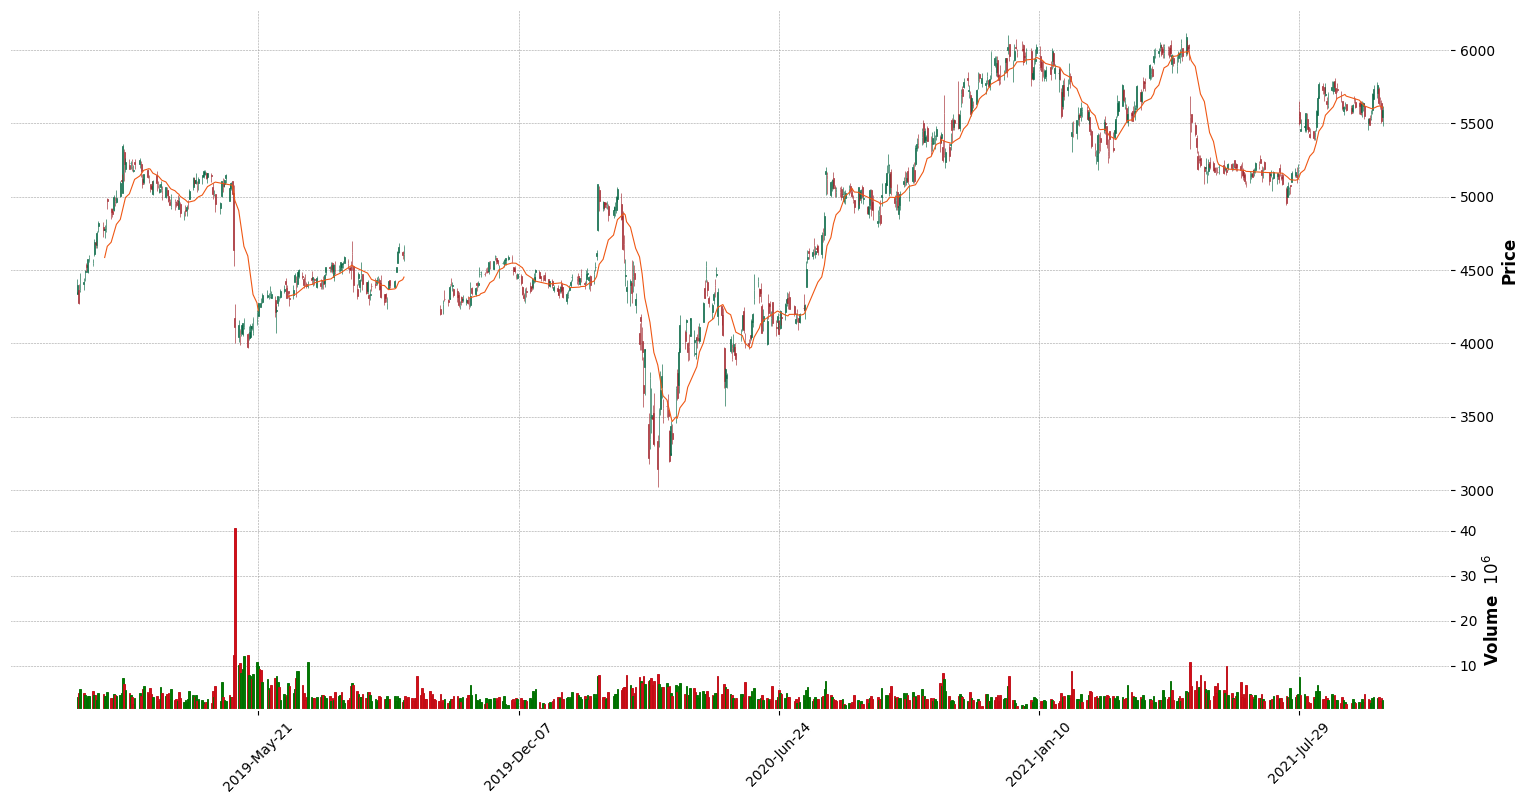

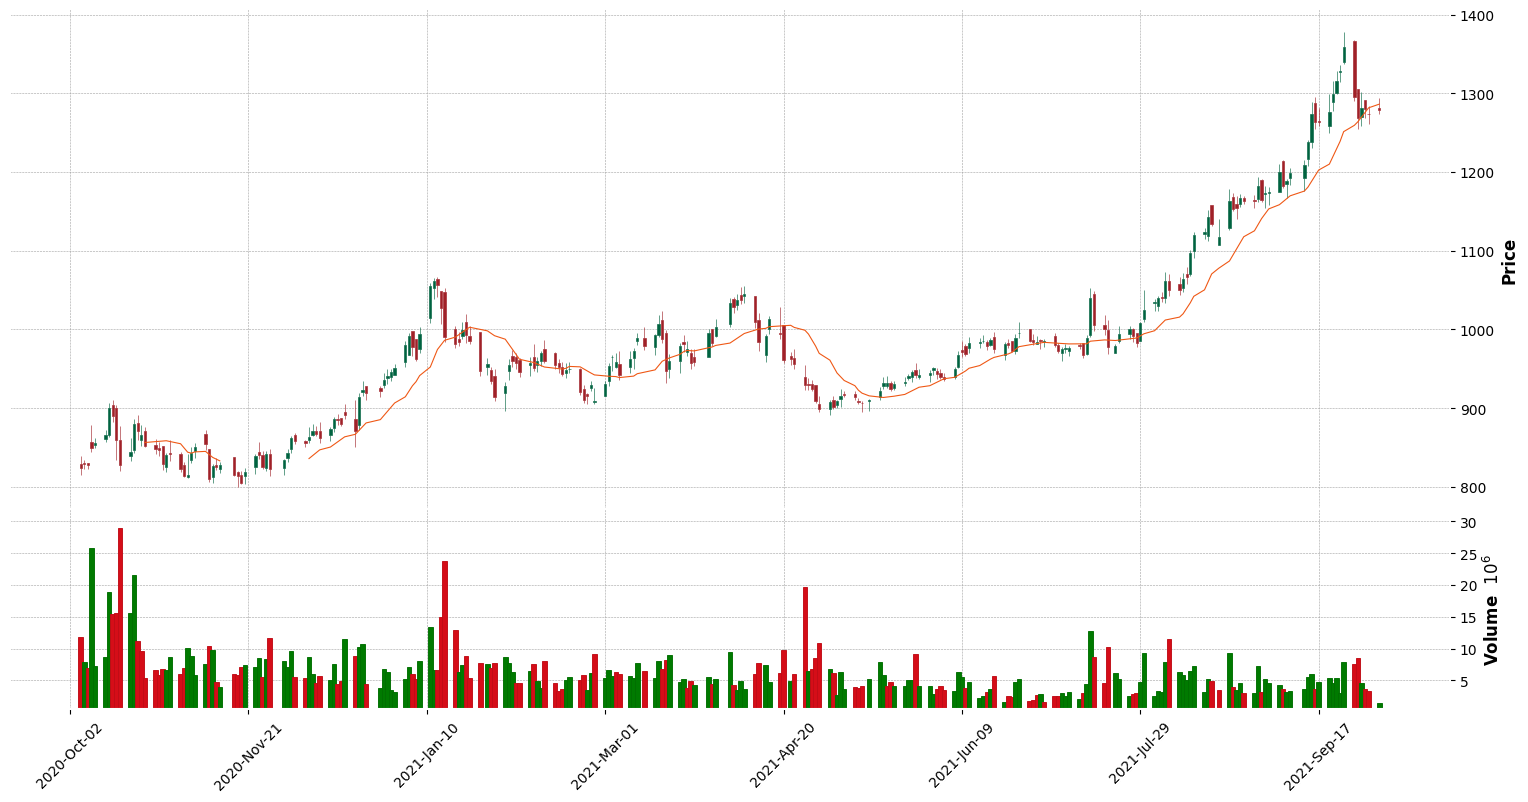

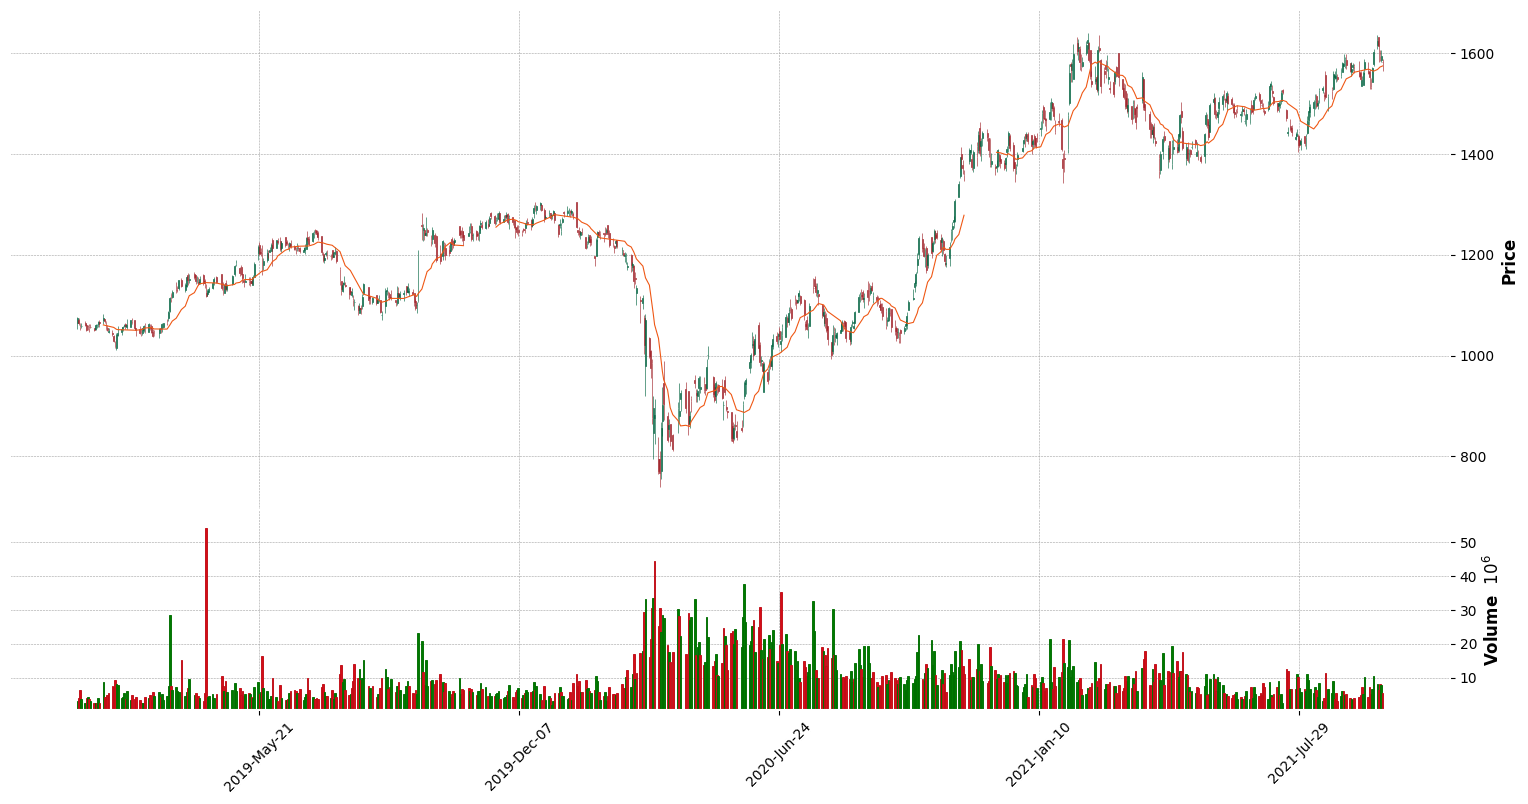

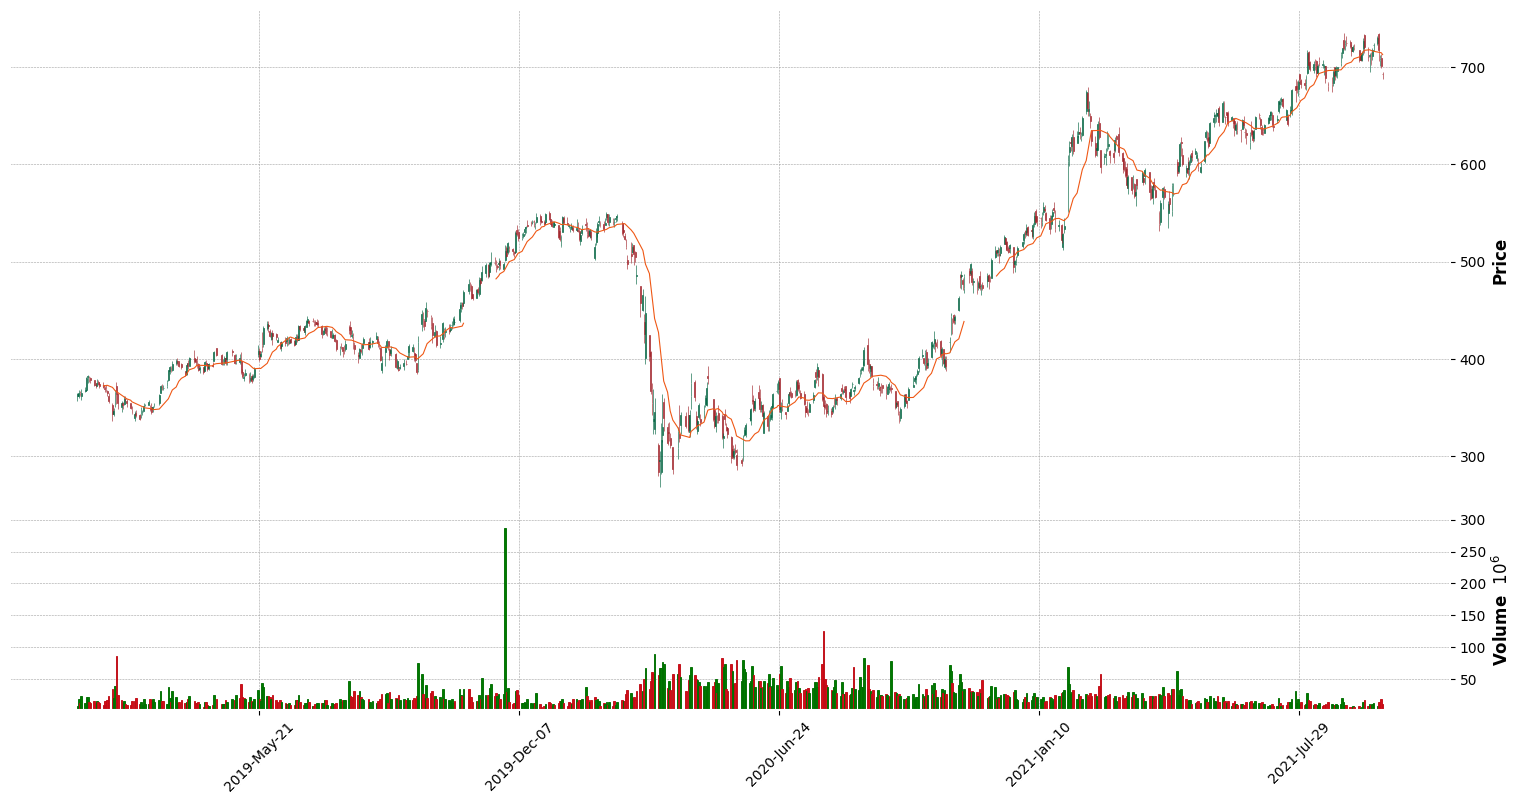

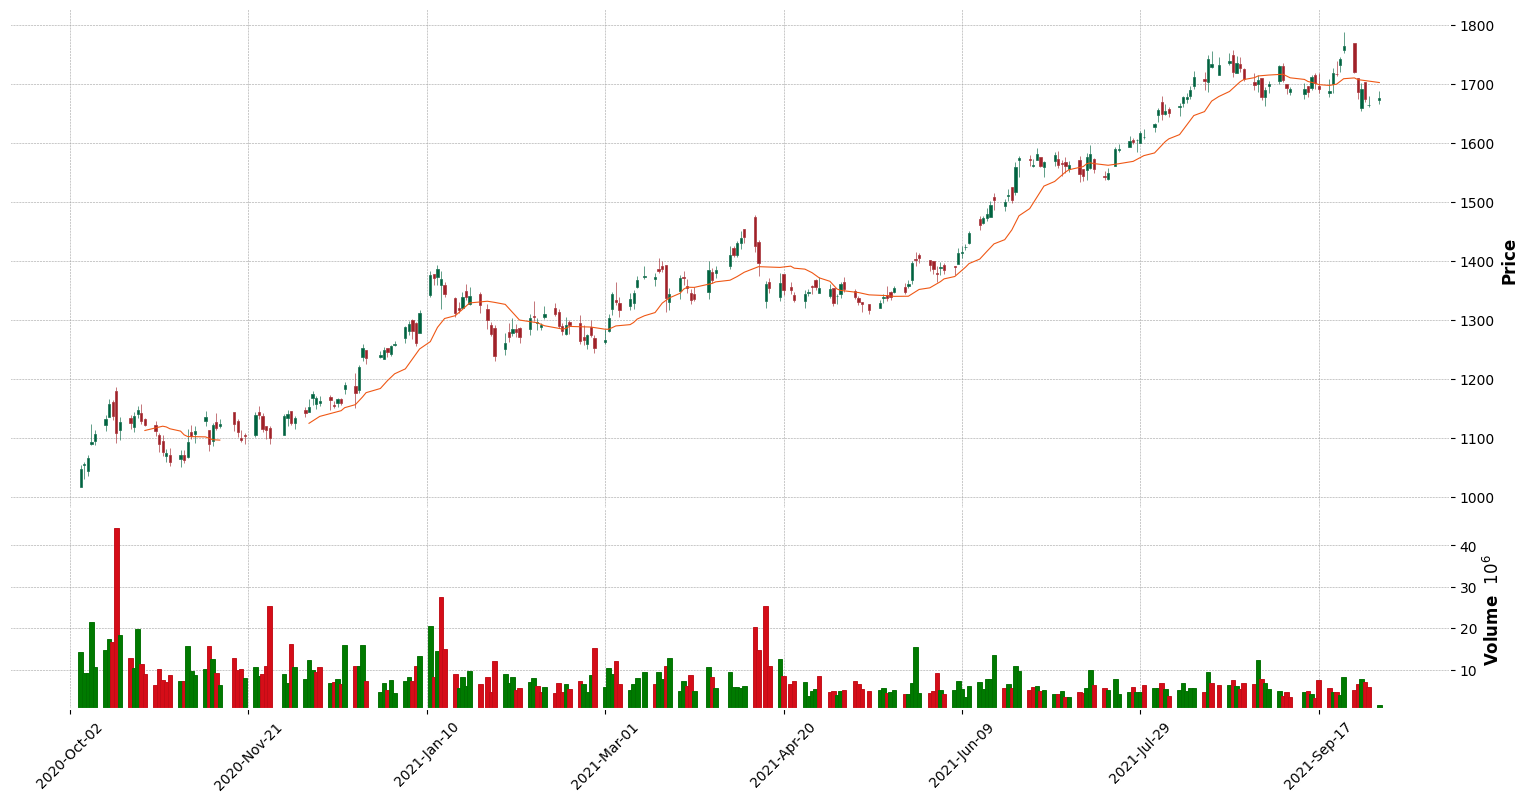

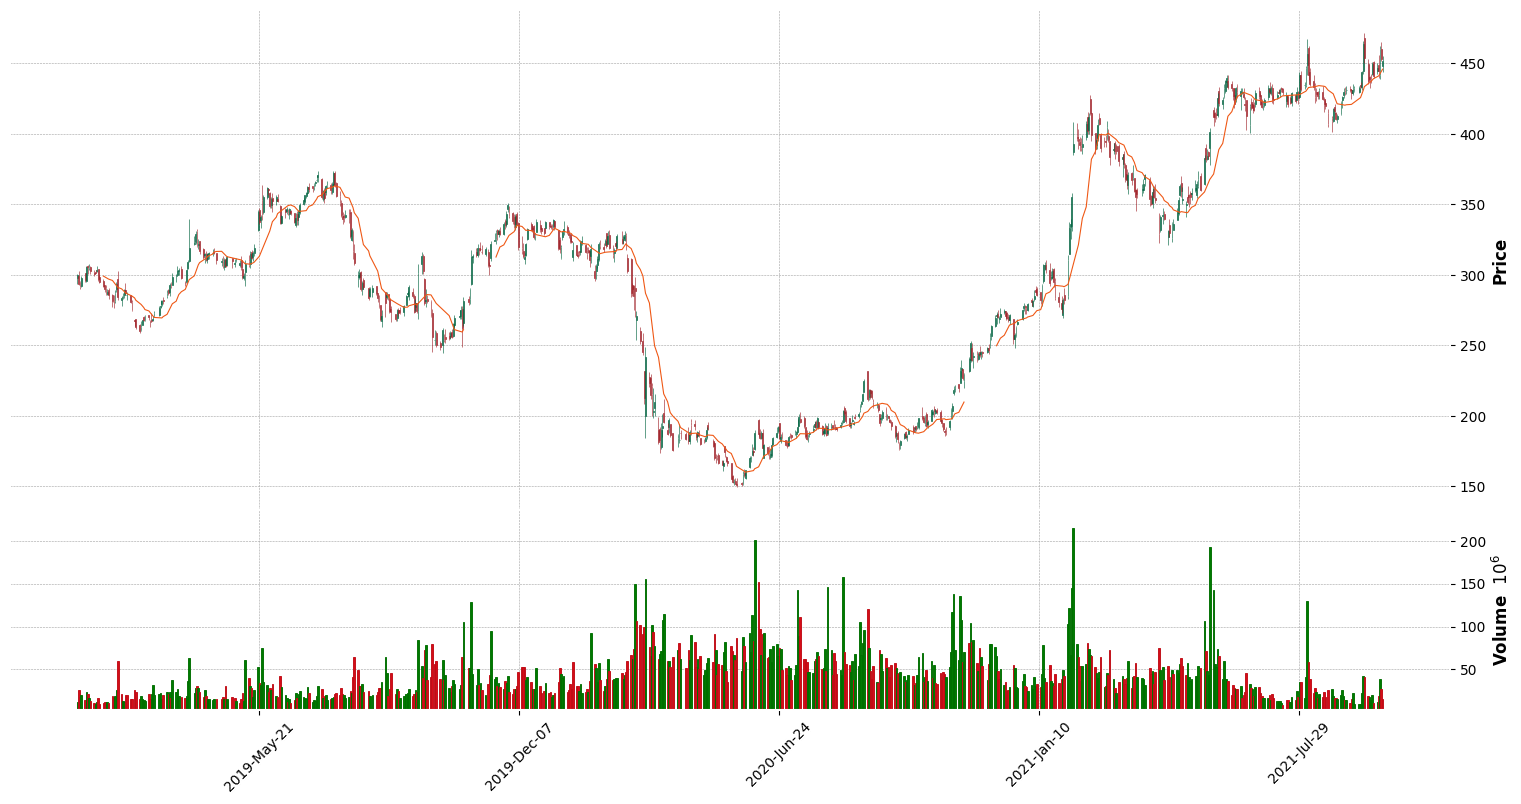

In [4]:
# Function to plot the stock values of each company separately, showing the opening, closing, high and low prices, including the volume traded

mpf.plot(cognizant, figsize = ((20, 10)), type='candle', style='charles', volume = True, show_nontrading=True, mav=(15))
mpf.plot(hcl, figsize = ((20, 10)), type='candle', style='charles', volume = True, show_nontrading=True, mav=(15))
mpf.plot(hdfc, figsize = ((20, 10)), type='candle', style='charles', volume = True, show_nontrading=True, mav=(15))
mpf.plot(icici, figsize = ((20, 10)), type='candle', style='charles', volume = True, show_nontrading=True, mav=(15))
mpf.plot(infosys, figsize = ((20, 10)), type='candle', style='charles', volume = True, show_nontrading=True, mav=(15))
mpf.plot(sbi, figsize = ((20, 10)), type='candle', style='charles', volume = True, show_nontrading=True, mav=(15))

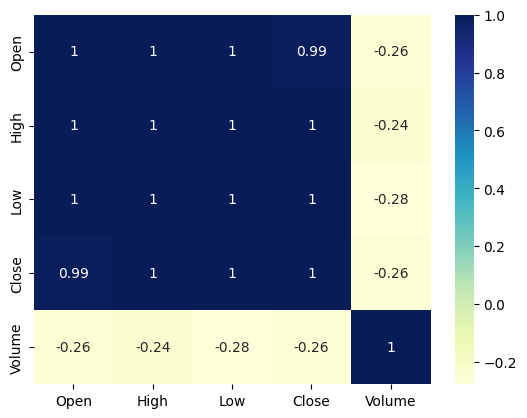

In [5]:
# Plotting the correlation between various prices for each company stock

sns.heatmap(cognizant.corr(), cmap="YlGnBu", annot=True)
# sns.heatmap(hcl.corr(), cmap="YlGnBu", annot=True)
# sns.heatmap(hdfc.corr(), cmap="YlGnBu", annot=True)
# sns.heatmap(icici.corr(), cmap="YlGnBu", annot=True)
# sns.heatmap(infosys.corr(), cmap="YlGnBu", annot=True)
# sns.heatmap(sbi.corr(), cmap="YlGnBu", annot=True)

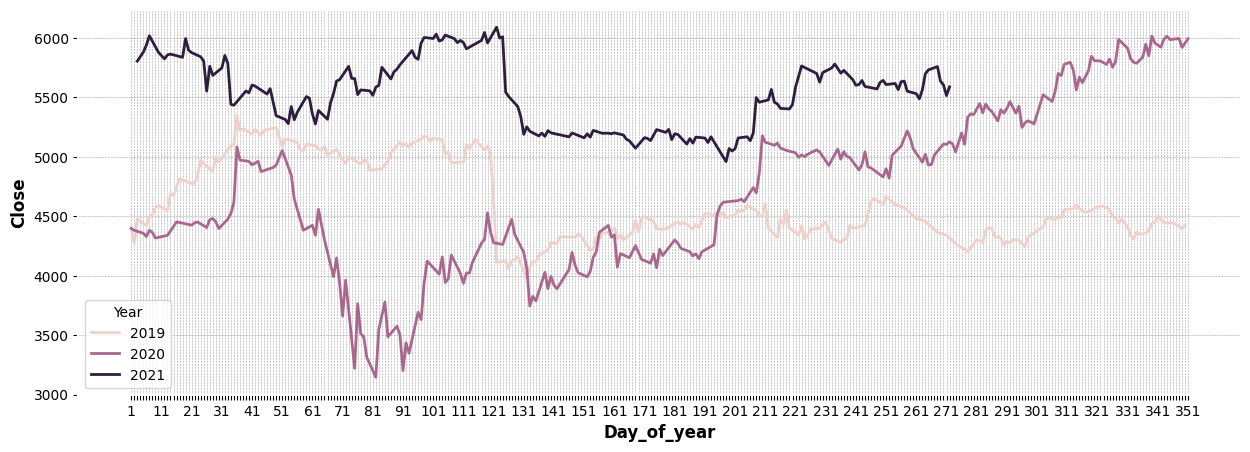

In [6]:
cognizant = process(cognizant)
hcl = process(hcl)
hdfc = process(hdfc)
icici = process(icici)
infosys = process(infosys)
sbi = process(sbi)

# Checking seasonality of a company stock
plot_seasonal(cognizant)

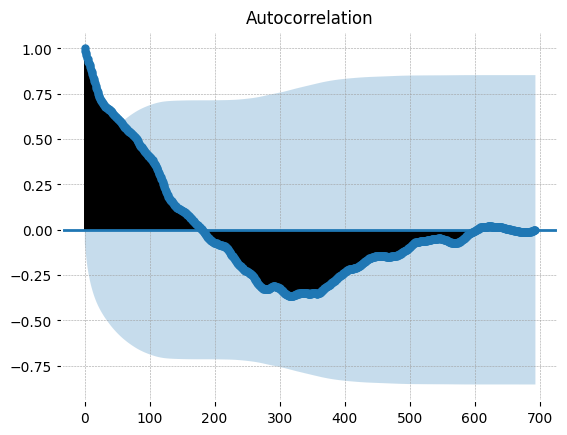

In [7]:
# Plotting the autocorrelation for stocks of each company
arr = np.array(cognizant['Close'])
plot_acf(arr, lags=len(arr)-1);

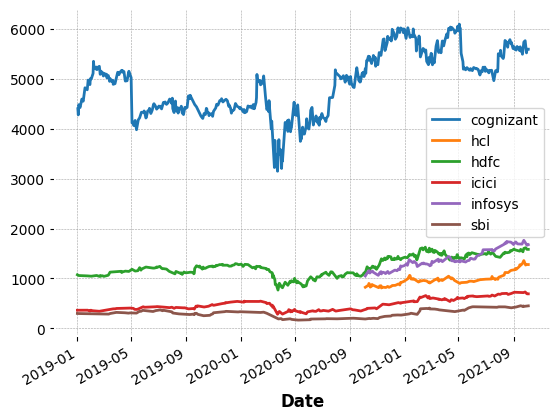

In [8]:
# Comparing various company stock prices
all_data = pd.concat([cognizant['Close'], hcl['Close'], hdfc['Close'], icici['Close'], infosys['Close'], sbi['Close']], axis=1)
all_data.columns = ["cognizant", "hcl", "hdfc", "icici","infosys", "sbi"]

all_data.interpolate('linear', inplace=True)

all_data.plot();

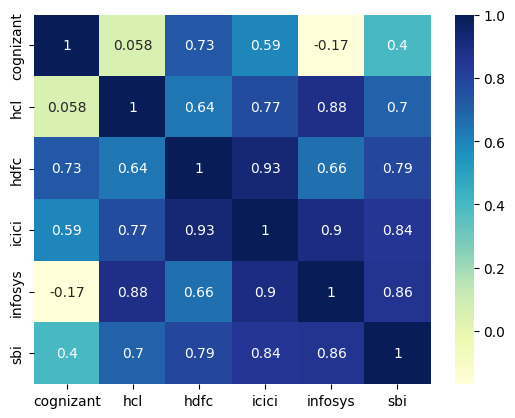

In [9]:
# Correlation between various company stocks
sns.heatmap(all_data.corr(), cmap="YlGnBu", annot=True);

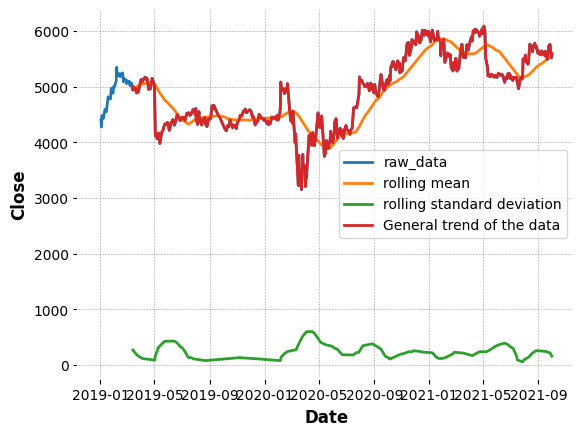

In [10]:
# Checking stationarity
cognizant['detrended_data'] = (cognizant['Close'] - cognizant['Close'].rolling(window=50).mean()) / cognizant['Close'].rolling(window=15).std()
cognizant['trend'] = cognizant['Close']-cognizant['detrended_data']

ax = sns.lineplot(cognizant.index, cognizant['Close'], label="raw_data")
ax = sns.lineplot(cognizant.index, cognizant['Close'].rolling(window=50).mean(), label="rolling mean")
ax = sns.lineplot(cognizant.index, cognizant['Close'].rolling(window=50).std(), label="rolling standard deviation")
ax = sns.lineplot(cognizant.index, cognizant['trend'], label="General trend of the data")

## Multiple models for each time series

In [11]:
column = 'sbi'
start, end = find_first_last(all_data[column])
arr = all_data[column][start:end]
train = arr[:-30]
val = list(arr[-30:])

### Exponential smoothing models

In [12]:
ses_model = SimpleExpSmoothing(train).fit()
ses_forecast = list(ses_model.forecast(30))
ses_error = calc_error(ses_forecast, val)

holt_model = Holt(train).fit(optimized = True)
holt_forecast = list(holt_model.forecast(30))
holt_error = calc_error(holt_forecast, val)

damped_model = ExponentialSmoothing(train, trend='mul', seasonal=None, damped=True).fit()
damped_forecast = list(damped_model.forecast(30))
damped_error = calc_error(damped_forecast, val)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)
/usr/local/lib/python3.7/dis

### ARIMA Model

In [13]:
# Checking for stationarity
result = adfuller(train.dropna())
print("0 differencing:")
print('\tADF Statistic: %f' % result[0])
print('\tp-value: %f' % result[1])

result = adfuller(train.diff().dropna())
print("1 differencing:")
print('\tADF Statistic: %f' % result[0])
print('\tp-value: %f' % result[1])

result = adfuller(train.diff().diff().dropna())
print("2 differencing:")
print('\tADF Statistic: %f' % result[0])
print('\tp-value: %f' % result[1])

0 differencing:
	ADF Statistic: -1.150493
	p-value: 0.694522
1 differencing:
	ADF Statistic: -9.650701
	p-value: 0.000000
2 differencing:
	ADF Statistic: -10.770432
	p-value: 0.000000


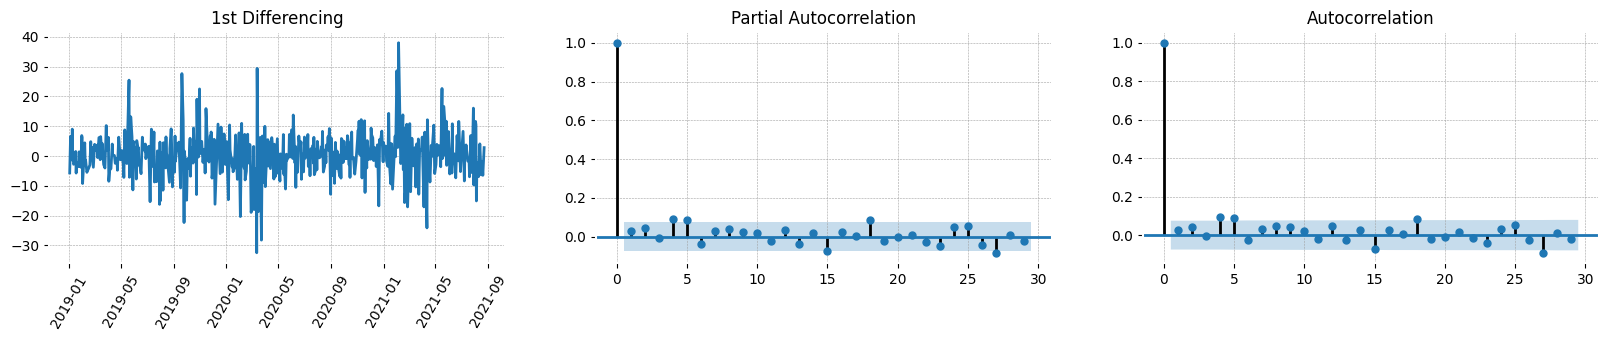

In [14]:
# PACF and ACF of the differentiated series
plt.rcParams.update({'figure.figsize':(20,3)})

fig, axes = plt.subplots(1, 3)
axes[0].plot(train.diff()); axes[0].set_title('1st Differencing')
axes[0].tick_params(axis = 'x', labelrotation =60)
plot_pacf(train.diff().dropna(), ax=axes[1])
plot_acf(train.diff().dropna(), ax=axes[2])
plt.show()

In [15]:
# Fitting ARIMA model
arima_model = ARIMA(train, order=(0, 1, 1)).fit(disp=-1)  
arima_pred, _, _ = arima_model.forecast(30, alpha=0.05)  # 95% conf
arima_error = calc_error(arima_pred, val)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


### Regression using SVR

In [16]:
arr = list(arr)

data = pd.DataFrame()
data['x1'] = arr[:-3]
data['x2'] = arr[1:-2]
data['x3'] = arr[2:-1]
data['y'] = arr[3:]

X_train = data[['x1', 'x2', 'x3']][:-30]
Y_train = data['y'][:-30]

X_test = data[['x1', 'x2', 'x3']][-30:]
Y_test = data['y'][-30:]


svr = SVR(kernel='linear')
svr.fit(X_train, Y_train)
svr_pred = svr.predict(X_test)
svr_error = calc_error(svr_pred, list(Y_test))

### Plotting the results of all models

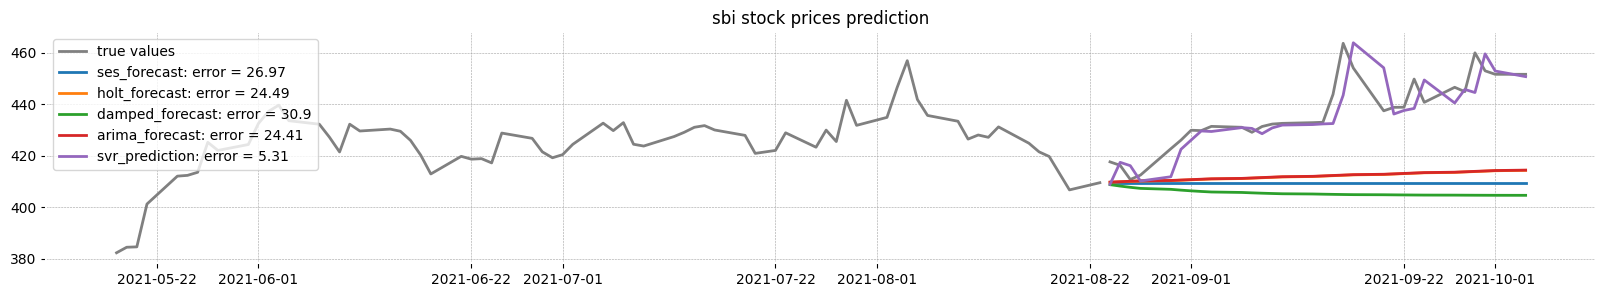

In [17]:
index = all_data.index[all_data[column].isnull() == False].tolist()
plt.plot(index[-100:-30], train[-70:], color = "gray");
plt.plot(index[-30:], val, color = "gray", label="true values");
plt.plot(index[-30:], ses_forecast, label=("ses_forecast: error = "+str(round(ses_error, 2))));
plt.plot(index[-30:], holt_forecast, label=("holt_forecast: error = "+str(round(holt_error, 2))));
plt.plot(index[-30:], damped_forecast, label=("damped_forecast: error = "+str(round(damped_error, 2))));
plt.plot(index[-30:], arima_pred, label=("arima_forecast: error = "+str(round(arima_error, 2))));
plt.plot(index[-30:], svr_pred, label=("svr_prediction: error = " + str(round(svr_error, 2))));
plt.legend();
name = column + " stock prices prediction"
plt.title(name);

## Making predictions using the best model

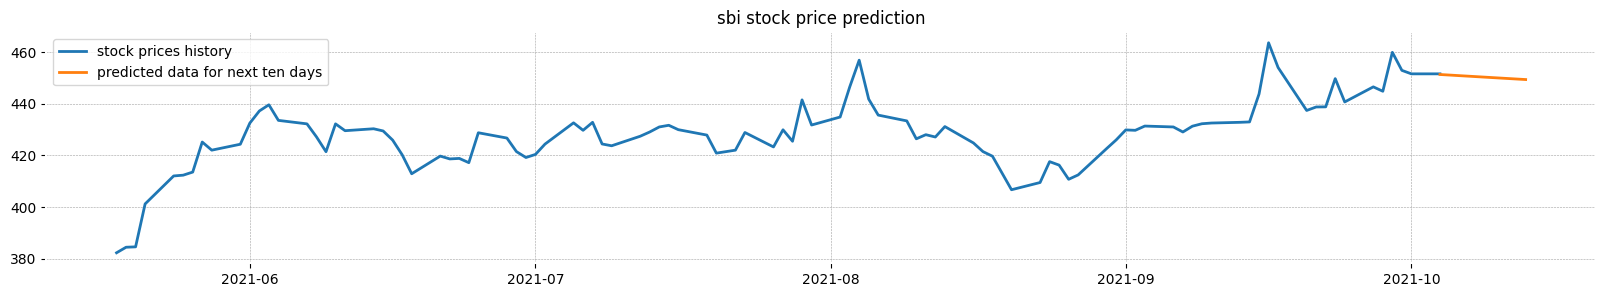

In [18]:
column = 'sbi'
start, end = find_first_last(all_data[column])
arr = list(all_data[column][start:end])

data = pd.DataFrame()
data['x1'] = arr[:-3]
data['x2'] = arr[1:-2]
data['x3'] = arr[2:-1]
data['y'] = arr[3:]

X_train = data[['x1', 'x2', 'x3']]
Y_train = data['y']

svr = SVR(kernel='linear')
svr.fit(X_train, Y_train)

pred = []
x1 = list(data['x2'])[-1]
x2 = list(data['x3'])[-1]
x3 = list(data['y'])[-1]
for i in range(10):
  X_test = pd.DataFrame({'x1':[x1], 'x2':[x2], 'x3':[x3]})
  pred.append(svr.predict(X_test)[0])
  x1 = x2
  x2 = x3
  x3 = pred[-1]


index = all_data.index[all_data[column].isnull() == False].tolist()
test_index = []
for x in range (10):
    test_index.append(end + datetime.timedelta(days = x))
name = column + " stock price prediction"

plt.plot(index[-100:], arr[-100:], label="stock prices history");
plt.plot(test_index, pred, label="predicted data for next ten days");
plt.legend();
plt.title(name);